### Model capacity experiments. 

For this experiment, only the figures are collected in the data folder, but they can be recreated by running the following notebook. 

In [1]:
%load_ext autoreload
%autoreload 2

pygame 2.5.2 (SDL 2.28.3, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
Interactive mode


In [ ]:
import pandas as pd
import numpy as np
import random

from pathlib import Path
import matplotlib.pyplot as plt

import hippo
from hippo import load_object, save_config, save_object 
from hippo.agents import HierarchicalAgent, load_hippo_agent
from hippo.agents.prefrontal_agent import PrefrontalCSCGModel

from hippo.environments.action_perception import action_perception_loop
from hippo.environments.w_maze import get_wmaze, WmazeTasks
from hippo.environments.high_level import generate_sequence


def fit_and_save_model(
    store_path,
    cycle_rules_every=8000,
    n_clones=10,
    added_task_size=0,
    n_rules=3,
):
    store_path.mkdir(exist_ok=True, parents=True)

    config = {
        "n_clones": n_clones,
        "seed": 0,
        "sequence_length": 8000,
        "cycle_rule_every": cycle_rules_every,
        "p_optim": 0.75,
        "n_rules": n_rules,
        "added_task_size": added_task_size,
    }

    np.random.seed(config["seed"])
    random.seed(config["seed"])

    states, actions = generate_sequence(
        sequence_length=config["sequence_length"],
        p_optim=config["p_optim"],
        cycle_rule_every=config["cycle_rule_every"],
        added_task_size=config["added_task_size"],
        n_rules=config["n_rules"],
    )

    n_obs = len(np.unique(states))
    n_clones = config["n_clones"] * np.ones(n_obs, dtype=np.int64)
    cscg = fit_cscg(states, actions, n_clones)

    save_object(actions, store_path / "actions.pkl")
    save_object(states, store_path / "states.pkl")
    save_object(
        cscg,
        store_path
        / f"nr:{n_rules}_nc:{n_clones[0]}_at:{added_task_size}_chmm_prefrontal_with_loc.pkl",
    )
    save_config(
        config,
        store_path
        / f"nr:{n_rules}_nc:{n_clones[0]}_at:{added_task_size}_config_chmm_prefrontal_with_loc.yml",
    )


def to_dataframe(logs, control_mode, agent_name, trial):
    d_new = {
        "trial": [trial for _ in range(len(logs["action"]))],
        "agent_name": [agent_name for _ in range(len(logs["action"]))],
        "control_mode": [control_mode for _ in range(len(logs["action"]))],
        "time": np.arange(len(logs["action"])),
        "action": logs["action"],
        "reward": 1.0 * logs["reward"],
        "pos_x": [pose[0] for pose in logs["pose"]],
        "pos_y": [pose[1] for pose in logs["pose"]],
        "pos_dir": [pose[2] for pose in logs["pose"]],
        "rules": logs["rules"],
        "inbound": logs["inbound"],
    }
    return pd.DataFrame.from_dict(d_new)


def run_experiment(
    n_clones,
    added_task_size,
    store_path_,
    n_rules_model=3,
    n_trials=20,
    n_steps=300,
    switch_rule_every=300,
    n_rules=3,
):
    """
    Runs the action control loop for an agent for multiple trials.
    A control and disruption scenario is ran and the metrics are stored
    unless the agent is random (does not use state to select action)
    """
    model_hippo = load_hippo_agent()
    model_hippo.use_epistemic = True

    tag = f"nr:{n_rules_model}_nc:{n_clones}_at:{added_task_size}"
    pf_cscg = load_object(store_path_ / f"{tag}_chmm_prefrontal_with_loc.pkl")
    model_pf = PrefrontalCSCGModel(pf_cscg, with_location=True)

    agent = HierarchicalAgent(
        model_pf=model_pf,
        model_hippo=model_hippo,
        fe_threshold=-14.8,
        name=f"CSCG_{n_clones}",
    )

    run_logs_df = pd.DataFrame()
    for trial in range(n_trials):
        np.random.seed(trial)
        random.seed(trial)
        control_key = "control"
        run_logs = action_perception_loop(
            get_wmaze(
                task_mode=WmazeTasks.TASK0,
                cycle_rules_every=switch_rule_every,
                n_rules=n_rules,
                cycle_rules_random=False,
            ),
            agent,
            n_steps,
            record_frames=False,
            record_agent_info=True,
            observable_reward=True,
            callbacks=[],
            observable_light=False,
            progress_bar=True,
        )

        df = to_dataframe(run_logs, control_key, agent.name, trial)
        run_logs_df = pd.concat([run_logs_df, df])

    name = f"{tag}.csv"
    print(store_path_ / name)
    run_logs_df.to_csv(store_path_ / name)

In [2]:
store_path = Path(hippo.__file__).parent.parent / "data/results"
store_path /= "experiment-appendix-capacity/runs"

store_path.mkdir(exist_ok=True, parents=True)

n_clones_list = [1, 2, 4, 8, 16, 32]
added_task_size_list = [0, 1, 2, 3]
n_rules_list = [1, 2, 3, 4, 5, 6, 7]

____

Fit all the models with different conditions

In [3]:
for n_clones in n_clones_list:
    fit_and_save_model(
        store_path / "clones_single_rule", 
        n_clones=n_clones, 
        n_rules=1,
        added_task_size=0,
        cycle_rules_every=8000,
    )
    fit_and_save_model(
        store_path / "clones_multiple_rule", 
        n_clones=n_clones, 
        n_rules=3, 
        cycle_rules_every=1000,
        added_task_size=0,
    )

Average number of clones: 1.0


  1%|          | 1/100 [00:00<01:19,  1.25it/s, train_bps=0.224]

Average number of clones: 1.0



  1%|          | 1/100 [00:00<00:01, 49.63it/s, train_bps=0.403]

Average number of clones: 2.0



  2%|▏         | 2/100 [00:00<00:01, 65.48it/s, train_bps=0.0302]


Average number of clones: 2.0


  3%|▎         | 3/100 [00:00<00:01, 73.59it/s, train_bps=0.313]


Average number of clones: 4.0


  2%|▏         | 2/100 [00:00<00:01, 61.42it/s, train_bps=0.000573]


Average number of clones: 4.0


  7%|▋         | 7/100 [00:00<00:01, 79.65it/s, train_bps=0.19]


Average number of clones: 8.0


  2%|▏         | 2/100 [00:00<00:01, 54.73it/s, train_bps=0.0127]


Average number of clones: 8.0


  3%|▎         | 3/100 [00:00<00:01, 53.72it/s, train_bps=0.0268]


Average number of clones: 16.0


  3%|▎         | 3/100 [00:00<00:01, 49.02it/s, train_bps=0.0503]


Average number of clones: 16.0


  3%|▎         | 3/100 [00:00<00:01, 48.92it/s, train_bps=0.0157]

Average number of clones: 32.0



  3%|▎         | 3/100 [00:00<00:03, 32.11it/s, train_bps=0.142]

Average number of clones: 32.0



  3%|▎         | 3/100 [00:00<00:03, 32.27it/s, train_bps=0.00972]


In [4]:
for added_task_size in added_task_size_list:
    fit_and_save_model(
        n_clones=10,
        store_path=store_path / "rule_length_single_rule", 
        added_task_size=added_task_size,
        n_rules=1,
        cycle_rules_every=8000
    )

    fit_and_save_model(
        n_clones=32,
        store_path=store_path / "rule_length_multiple_rule", 
        added_task_size=added_task_size,
        n_rules=3,
        cycle_rules_every=150
    )

Average number of clones: 10.0


  3%|▎         | 3/100 [00:00<00:01, 57.31it/s, train_bps=0.00311]


Average number of clones: 32.0


  3%|▎         | 3/100 [00:00<00:02, 32.57it/s, train_bps=0.0391]

Average number of clones: 10.0



  3%|▎         | 3/100 [00:00<00:01, 58.38it/s, train_bps=0.0025]


Average number of clones: 32.0


  4%|▍         | 4/100 [00:00<00:02, 34.88it/s, train_bps=0.0302]

Average number of clones: 10.0



  3%|▎         | 3/100 [00:00<00:01, 59.33it/s, train_bps=0.0529]


Average number of clones: 32.0


  4%|▍         | 4/100 [00:00<00:02, 34.37it/s, train_bps=0.0457]

Average number of clones: 10.0



  3%|▎         | 3/100 [00:00<00:01, 58.90it/s, train_bps=0.00126]


Average number of clones: 32.0


  3%|▎         | 3/100 [00:00<00:02, 32.52it/s, train_bps=0.0514]


In [5]:
for n_rules in n_rules_list: 
    fit_and_save_model(
        store_path / "n_rules_multiple", 
        n_clones=32,
        added_task_size=0, 
        n_rules=n_rules, 
        cycle_rules_every=150
    )

Average number of clones: 32.0


  5%|▌         | 5/100 [00:00<00:02, 35.75it/s, train_bps=0.0252]


Average number of clones: 32.0


  5%|▌         | 5/100 [00:00<00:02, 34.82it/s, train_bps=0.0444]

Average number of clones: 32.0



  3%|▎         | 3/100 [00:00<00:03, 32.29it/s, train_bps=0.0391]

Average number of clones: 32.0



  3%|▎         | 3/100 [00:00<00:03, 31.94it/s, train_bps=0.0468]

Average number of clones: 32.0



  3%|▎         | 3/100 [00:00<00:02, 32.71it/s, train_bps=0.031]

Average number of clones: 32.0



  4%|▍         | 4/100 [00:00<00:02, 33.78it/s, train_bps=0.0366]

Average number of clones: 32.0



  5%|▌         | 5/100 [00:00<00:02, 36.16it/s, train_bps=0.0382]


____ 



Run experiments and visualize performance

In [6]:
n_trials = 5
n_steps = 900 
rule_switch_at = 150 

In [7]:
for n_clones in n_clones_list: 
    print("Running for ", n_clones, " 1 Rule")
    run_experiment(
        n_clones=n_clones, 
        added_task_size=0, 
        n_rules_model=1,
        store_path_=store_path / "clones_single_rule", 
        n_trials=n_trials,
        n_steps=n_steps, 
        switch_rule_every=n_steps, 
        n_rules=1
    )

    print("Running for ", n_clones, " 3 Rules")
    run_experiment(
        n_clones=n_clones, 
        added_task_size=0, 
        n_rules_model=3,
        store_path_=store_path / "clones_multiple_rule", 
        n_trials=n_trials,
        n_steps=n_steps, 
        switch_rule_every=rule_switch_at, 
        n_rules=3
    )

Running for  1  1 Rule


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_single_rule/nr:1_nc:1_at:0.csv
Running for  1  3 Rules


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_multiple_rule/nr:3_nc:1_at:0.csv
Running for  2  1 Rule


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_single_rule/nr:1_nc:2_at:0.csv
Running for  2  3 Rules


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_multiple_rule/nr:3_nc:2_at:0.csv
Running for  4  1 Rule


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_single_rule/nr:1_nc:4_at:0.csv
Running for  4  3 Rules


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_multiple_rule/nr:3_nc:4_at:0.csv
Running for  8  1 Rule


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_single_rule/nr:1_nc:8_at:0.csv
Running for  8  3 Rules


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_multiple_rule/nr:3_nc:8_at:0.csv
Running for  16  1 Rule


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_single_rule/nr:1_nc:16_at:0.csv
Running for  16  3 Rules


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_multiple_rule/nr:3_nc:16_at:0.csv
Running for  32  1 Rule


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_single_rule/nr:1_nc:32_at:0.csv
Running for  32  3 Rules


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/clones_multiple_rule/nr:3_nc:32_at:0.csv


In [8]:
for added_task_size in added_task_size_list:
    run_experiment(
        n_clones=10, 
        added_task_size=added_task_size, 
        n_rules_model=1,
        store_path_=store_path / "rule_length_single_rule", 
        n_trials=n_trials,
        n_steps=n_steps, 
        switch_rule_every=n_steps, 
        n_rules=1
    )

    run_experiment(
        n_clones=32, 
        added_task_size=added_task_size, 
        n_rules_model=3,
        store_path_=store_path / "rule_length_multiple_rule", 
        n_trials=n_trials,
        n_steps=n_steps, 
        switch_rule_every=rule_switch_at, 
        n_rules=3
    )

/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/rule_length_single_rule/nr:1_nc:10_at:0.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/rule_length_multiple_rule/nr:3_nc:32_at:0.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/rule_length_single_rule/nr:1_nc:10_at:1.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/rule_length_multiple_rule/nr:3_nc:32_at:1.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/rule_length_single_rule/nr:1_nc:10_at:2.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/rule_length_multiple_rule/nr:3_nc:32_at:2.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/rule_length_single_rule/nr:1_nc:10_at:3.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/rule_length_multiple_rule/nr:3_nc:32_at:3.csv


In [9]:
n_steps_n_rules = rule_switch_at * 7
for n_rules in n_rules_list: 
    run_experiment(
        n_clones=32, 
        added_task_size=0, 
        n_rules_model=n_rules,
        store_path_=store_path / "n_rules_multiple", 
        n_trials=n_trials,
        n_steps=n_steps_n_rules, 
        switch_rule_every=rule_switch_at, 
        n_rules=n_rules
    )

/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/n_rules_multiple/nr:1_nc:32_at:0.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/n_rules_multiple/nr:2_nc:32_at:0.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/n_rules_multiple/nr:3_nc:32_at:0.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/n_rules_multiple/nr:4_nc:32_at:0.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/n_rules_multiple/nr:5_nc:32_at:0.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/n_rules_multiple/nr:6_nc:32_at:0.csv


/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

/Users/toon.vandemaele/Projects/hippocampus-models/data/paper-results/experiment-appendix-capacity/runs/n_rules_multiple/nr:7_nc:32_at:0.csv


In [16]:
def inferred_rule(data_tot):
    for trial in data_tot['trial'].unique():
        print("Trial", trial)
        data = data_tot[data_tot['trial'] == trial]
        data = data[data["pos_y"] == 1]
        datat = data[data["pos_dir"] == 3]

        for i in range(0, n_steps, rule_switch_at):
            data = datat[datat['time'] > i+50]
            data = data[data['time'] < i+rule_switch_at]

            r = data['reward'].tolist()
            #print(np.mean(r), r)
            corrects = []
            print(len(r))
            for i in range(len(r)-4): 
                c = np.sum(r[i:i+4]) == 4
                corrects.append(c)
        
            print(f"{np.sum(corrects)/len(corrects)*100:0.02f}%", "\tfor rule ", data['rules'].unique()[0])

        print()

    return

n_clones = 32
tag = f"nr:3_nc:{n_clones}_at:0"
data = pd.read_csv(store_path / f"rule_length_multiple_rule/{tag}.csv")
inferred_rule(data)

Trial 0
8
75.00% 	for rule  0
7
100.00% 	for rule  1
7
100.00% 	for rule  2
7
33.33% 	for rule  0
7
0.00% 	for rule  1
7
66.67% 	for rule  2

Trial 1
8
75.00% 	for rule  0
6
0.00% 	for rule  1
7
66.67% 	for rule  2
7
0.00% 	for rule  0
6
100.00% 	for rule  1
6
100.00% 	for rule  2

Trial 2
7
100.00% 	for rule  0
6
100.00% 	for rule  1
7
100.00% 	for rule  2
8
50.00% 	for rule  0
7
0.00% 	for rule  1
7
66.67% 	for rule  2

Trial 3
7
66.67% 	for rule  0
6
0.00% 	for rule  1
7
100.00% 	for rule  2
8
0.00% 	for rule  0
7
0.00% 	for rule  1
7
66.67% 	for rule  2

Trial 4
8
0.00% 	for rule  0
7
100.00% 	for rule  1
6
100.00% 	for rule  2
7
33.33% 	for rule  0
6
0.00% 	for rule  1
7
100.00% 	for rule  2



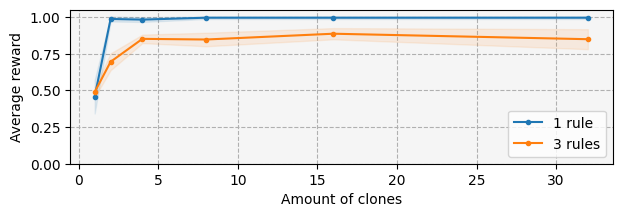

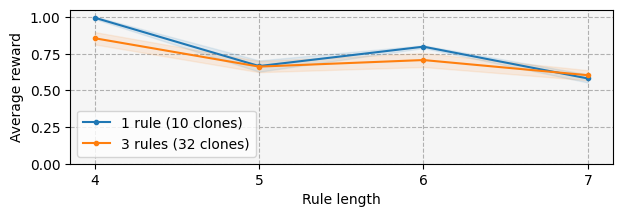

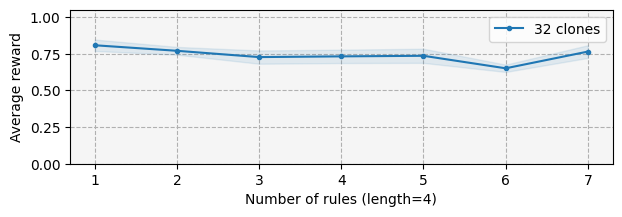

In [20]:
def format_ax(a):
    a.set_facecolor("whitesmoke")
    a.grid("on", linestyle="dashed")
    a.set_axisbelow(True)

def plot_sequence(vals, label, ax, color='b'):
    xyc = np.array([[k, v.mean().item(), 1.96 * v.std().item() / np.sqrt(v.size)] for k, v in vals.items()])
    x = xyc[:, 0]
    y = xyc[:, 1]
    c = xyc[:, 2]
    x, y, ci = x[x.argsort()], y [x.argsort()], c[x.argsort()]

    ax.fill_between(x, (y-ci), (y+ci), color=color, alpha=.1)
    ax.plot(x,y, marker='.', label=label, color=color)

def get_mean_reward(data):
    data = data[data["pos_y"] == 1]
    data = data[data["pos_dir"] == 3]

    ds = []
    for i in range(0, data['time'].max(), rule_switch_at):
        d = data[data['time'] > i]
        d = d[d['time'] > (i+50)]
        d = d[d['time'] < (i+rule_switch_at)]
        ds.append(d)
    
    data = pd.concat(ds)

    return  data.groupby(['trial']).mean(['reward'])['reward']


def plot_performance(n_clones_list, added_length_list, n_rules_list):

    # N clones values
    vals_nc_single  = {}
    vals_nc_multiple  = {}
    for n_clones in n_clones_list:
        tag = f"nr:1_nc:{n_clones}_at:0"
        data = pd.read_csv(store_path / f"clones_single_rule/{tag}.csv")
        vals_nc_single[n_clones] = get_mean_reward(data)


        tag = f"nr:3_nc:{n_clones}_at:0"
        data = pd.read_csv(store_path / f"clones_multiple_rule/{tag}.csv")
        vals_nc_multiple[n_clones] = get_mean_reward(data)

    # added task length values
    vals_at_single = {}
    vals_at_multiple = {}
    n_clones = 32
    for added_length in added_length_list:
        tag = f"nr:1_nc:10_at:{added_length}"
        data = pd.read_csv(store_path / f"rule_length_single_rule/{tag}.csv")
        vals_at_single[added_length] = get_mean_reward(data)

        tag = f"nr:3_nc:32_at:{added_length}"
        data = pd.read_csv(store_path / f"rule_length_multiple_rule/{tag}.csv")
        vals_at_multiple[added_length] = get_mean_reward(data)

    # n rules values
    vals_nr = {}
    n_clones = 32
    for n_rules in n_rules_list:
        tag = f"nr:{n_rules}_nc:{n_clones}_at:0"
        data = pd.read_csv(store_path / f"n_rules_multiple/{tag}.csv")
        vals_nr[n_rules] = get_mean_reward(data)

    # =
    fig, ax = plt.subplots(1,1,figsize=(7, 2))
    format_ax(ax)
    plot_sequence(vals_nc_single, "1 rule", ax, color='tab:blue')
    plot_sequence(vals_nc_multiple, "3 rules", ax, color='tab:orange')
    ax.set_xlabel('Amount of clones')
    ax.set_ylabel("Average reward")
    ax.legend()
    ax.set_ylim([0, 1.05])
    plt.savefig(store_path / "capacity_plot_a.svg", bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(1,1,figsize=(7, 2))
    format_ax(ax)
    plot_sequence(vals_at_single, "1 rule (10 clones)", ax, color='tab:blue')
    plot_sequence(vals_at_multiple, "3 rules (32 clones)", ax, color='tab:orange')
    ax.set_xlabel('Rule length')
    ax.set_ylabel("Average reward")
    ax.legend()
    ax.set_xticks([0, 1,2,3])
    ax.set_xticklabels([4, 5, 6, 7])
    ax.set_ylim([0, 1.05])
    plt.savefig(store_path / "capacity_plot_b.svg", bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(1,1,figsize=(7, 2))
    format_ax(ax)
    plot_sequence(vals_nr, "32 clones", ax, color='tab:blue')
    ax.set_xlabel('Number of rules (length=4)')
    ax.set_ylabel("Average reward")
    ax.set_ylim([0, 1.05])
    ax.legend()
    plt.savefig(store_path / "capacity_plot_c.svg", bbox_inches='tight')
    plt.show()
    # =


plot_performance(n_clones_list, added_task_size_list, n_rules_list)